In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from torchcps.kernel.rkhs import GaussianKernel
from torchcps.kernel.nn import (
    KernelConv,
    KernelMap,
    KernelGraphFilter,
    KernelPool,
    KernelNorm,
    Mixture,
)

In [3]:
# create a datset of 2D signals with noise
n_samples = 50_000
n_dimensions = 2
n_measurements = 20

with torch.no_grad():
    targets = 50 * torch.rand(n_samples, n_dimensions) - 25
    # convert to polar coordinates
    targets_range = torch.norm(targets, dim=-1)
    targets_bearing = torch.atan2(targets[..., 1], targets[..., 0])
    # add noise to make measurements
    measurements_range = (
        targets_range[..., None] + torch.randn(n_samples, n_measurements) * 1.0
    )
    measurements_bearing = (
        targets_bearing[..., None] + torch.randn(n_samples, n_measurements) * 0.5
    )
    # convert back to cartesian coordinates
    measurements = torch.stack(
        [
            measurements_range * torch.cos(measurements_bearing),
            measurements_range * torch.sin(measurements_bearing),
        ],
        dim=-1,
    )

In [4]:
# evaluate naive strategy of taking mean of measurements
input_mean = measurements.mean(dim=1)
(input_mean - targets).abs().mean()

tensor(1.8047)

In [5]:
in_weights = 1
out_weights = 1

n_channels = 1
max_kernels = 200
n_weights = 32
filter_kernels = 9
fixed_positions = False
sigma = [12.0, 6.0, 3.0]
filter_taps = 4
penalty_weight = 1e-6


class Model(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)

        self.n_layers = len(sigma)
        self.nonlinearity = KernelMap(nn.ReLU())
        self.readin = KernelMap(nn.Linear(in_weights, n_weights))
        self.readout = KernelMap(nn.Linear(n_weights, out_weights))
        self.pool = KernelPool(
            out_kernels=max_kernels,
            kernel=GaussianKernel(),
            strategy="largest",
            fit=False,
        )

        conv_layers = []
        norm_layers = []
        graph_layers = []
        for l in range(self.n_layers):
            norm_layers += [KernelNorm(n_channels, n_weights)]
            conv_layers += [
                KernelConv(
                    filter_kernels=filter_kernels,
                    in_channels=n_channels,
                    out_channels=n_channels,
                    n_dimensions=2,
                    kernel_spread=sigma[l],
                    fixed_positions=fixed_positions,
                    n_weights=n_weights,
                )
            ]
            graph_layers += [
                KernelGraphFilter(
                    kernel=GaussianKernel(sigma[l]),
                    in_weights=n_weights,
                    out_weights=n_weights,
                    filter_taps=filter_taps,
                )
            ]
        self.norm_layers = nn.ModuleList(norm_layers)
        self.conv_layers = nn.ModuleList(conv_layers)
        self.graph_layers = nn.ModuleList(graph_layers)

    def forward(self, input: Mixture):
        penalty = torch.zeros(1, device=input.weights.device)

        x = self.readin(input)
        x = self.nonlinearity(x)
        for l in range(self.n_layers):
            x = self.norm_layers[l](x)
            x = self.conv_layers[l](x)
            x = self.graph_layers[l](x)
            x = self.nonlinearity(x)
            if l < self.n_layers - 1:
                penalty += x.weights.abs().sum()
                x = self.pool(x)
        output: Mixture = self.readout(x)
        return output, penalty

In [6]:
from torch.optim import AdamW
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader

dataset = TensorDataset(measurements.cuda(), targets.cuda())
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

model = Model().cuda()

# positions should not be regularized
parameters = list(model.named_parameters())
positions = [p for n, p in parameters if "_positions" in n]
other = [p for n, p in parameters if "_positions" not in n]
optimizer = AdamW(
    [dict(params=positions, lr=1e-4, weight_decay=0.0), dict(params=other)],
    lr=5e-3,
    weight_decay=0,
)

mse_values = []
for i in range(5):
    pbar = tqdm(dataloader, total=len(dataloader))
    for x, y in pbar:
        x = x[:, None, ...]
        y = y[:, None, None, :]
        x_weights = torch.ones(*x.shape[:-1], device="cuda")[..., None]
        y_weights = torch.ones(*y.shape[:-1], device="cuda")[..., None]
        (z, z_weights), penalty = model.forward(Mixture(x, x_weights))

        kernel = GaussianKernel(sigma[-1])
        mse = kernel.squared_error(y, y_weights, z, z_weights).mean(0).sum()
        mse_values.append(mse.item())
        pbar.set_postfix(mse=mse.item())

        loss = mse + penalty_weight * penalty
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

0.37898505926132203


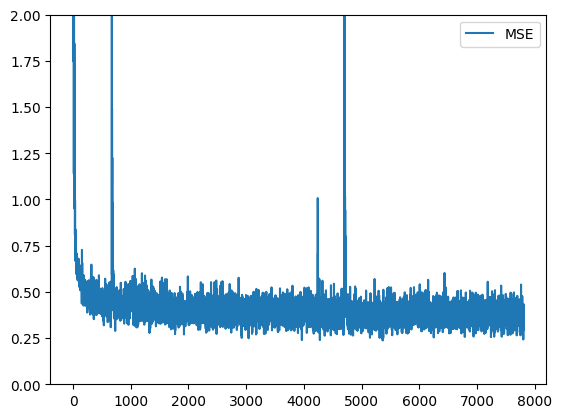

In [7]:
print(np.mean(mse_values[-10:]))

plt.figure()
plt.plot(mse_values, label="MSE")
plt.legend()
plt.ylim(0, 2)
plt.show()

In [8]:
def raster_rkhs(X: Mixture, sigma: float, width: float, resolution: int):
    XY = (
        torch.stack(
            torch.meshgrid(
                torch.linspace(-width / 2, width / 2, resolution),
                torch.linspace(-width / 2, width / 2, resolution),
            ),
            dim=-1,
        )
        .reshape(-1, 2)
        .to(X.positions.device)
    )
    kernel = GaussianKernel(sigma)
    values = kernel(XY, X.positions[0, 0]) @ X.weights
    XY = XY.reshape(resolution, resolution, 2).detach()
    values = values.reshape(resolution, resolution).detach()
    return values, XY

In [9]:
n_test = 100
indices = np.random.choice(n_samples, n_test, replace=False)

model.eval()
mae_mean = 0
mae_mode = 0
with torch.no_grad():
    for idx in tqdm(indices):
        x = measurements[None, idx, None, ...].cuda()
        y = targets[None, idx, None, None, :].cuda()
        x_weights = torch.ones(*x.shape[:-1], device=x.device)[..., None]
        y_weights = torch.ones(*y.shape[:-1], device=y.device)[..., None]
        Z, _ = model(Mixture(x, x_weights))

        # output argmax
        values, XY = raster_rkhs(Z, sigma[-1], 100, 1000)
        # expectation
        mean_xy = (XY * values[..., None]).sum((0, 1)) / values.sum()
        mae_mean += ((mean_xy - y.squeeze()).abs()).sum() / n_test
        # mode
        mode_xy = XY.reshape(-1, 2)[torch.argmax(values)]
        mae_mode += ((mode_xy - y.squeeze()).abs()).sum() / n_test
print(f"Mean Absolute Error (MEAN): {mae_mean.item():.2f}")
print(f"Mean Absolute Error (MODE): {mae_mode.item():.2f}")

  0%|          | 0/100 [00:00<?, ?it/s]

/home/damow/.pyenv/versions/3.11.4/envs/torchcps/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Mean Absolute Error (MEAN): 38.62
Mean Absolute Error (MODE): 48.19


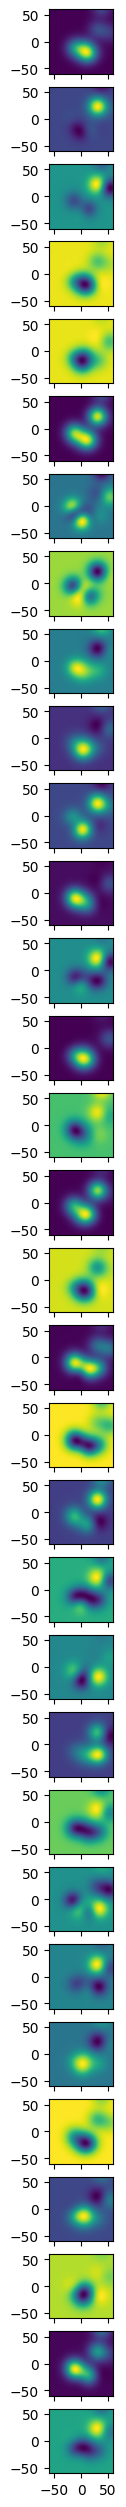

In [10]:
def raster_filter(X: Mixture, sigma: float, weight_idx, width: float, resolution: int):
    X_ = Mixture(X.positions, X.weights[..., weight_idx, None].contiguous())
    return raster_rkhs(X_, sigma, width, resolution)[0].detach().cpu()


# Plot the CNN Filter at the lth layer
l = 0
conv_layers = model.conv_layers
positions = conv_layers[l].kernel_positions
weights = conv_layers[l].kernel_weights
n_weights = weights.shape[3]
fig, axs = plt.subplots(
    nrows=n_weights, figsize=(1, n_weights), sharex=True, sharey=True
)
for i in range(n_weights):
    rkhs = Mixture(positions, weights)
    width = sigma[l] * 10
    extent = np.array([-1, 1, -1, 1]) * width / 2
    if n_weights > 1:
        ax = axs[i]  # type: ignore
    else:
        ax = axs
    ax.imshow(
        raster_filter(rkhs, sigma[l], i, width=width, resolution=128),
        extent=extent,
        origin="lower",
    )
plt.show()

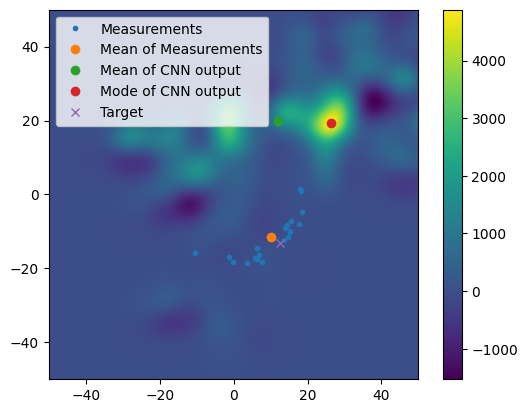

In [17]:
idx = np.random.randint(0, n_samples)
resolution = 1000

with torch.no_grad():
    x = measurements[None, idx, None, ...].cuda()
    y = targets[None, idx, None, None, :].cuda()
    x_weights = torch.ones(*x.shape[:-1], device=x.device)[..., None]
    y_weights = torch.ones(*y.shape[:-1], device=y.device)[..., None]

    model.eval()
    with torch.no_grad():
        z, z_weights = model(Mixture(x, x_weights))[0]
    model.train()

    # squeeze all the tensors
    x = x.squeeze().cpu()
    y = y.squeeze().cpu()

    extent = [-50, 50, -50, 50]
    values, XY = raster_rkhs(Mixture(z, z_weights), sigma[-1], 100, 1000)
    # naive way to make predictions
    input_mean = x.mean(0)
    # expectation
    mean_xy = (XY * values[..., None]).sum((0, 1)) / values.sum()
    # mode
    mode_xy = XY.reshape(-1, 2)[torch.argmax(values)]

plt.figure()
plt.imshow(values.T.cpu().detach(), extent=extent, origin="lower")

plt.plot(*x.T, ".", label="Measurements")
plt.plot(*input_mean, "o", label="Mean of Measurements")
plt.plot(*mean_xy.detach().cpu(), "o", label="Mean of CNN output")
plt.plot(*mode_xy.detach().cpu(), "o", label="Mode of CNN output")
plt.plot(*y, "x", label="Target")

plt.xlim(extent[0], extent[1])
plt.ylim(extent[2], extent[3])

plt.legend()
plt.colorbar()
plt.show()